<a href="https://colab.research.google.com/github/SheetalData/Secom-Assignment/blob/main/BORUTA_KNN_OVERSAMPLING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DATA IMPORTATION

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from scipy.stats import shapiro
# imputer
from sklearn.impute import SimpleImputer, KNNImputer


url1 ='https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data'
names = ["feature" + str(x) for x in range(1, 591)]
df1 = pd.read_csv(url1,sep=" ", names=names, na_values = "NaN",header=None)
df1.head()

url2 ='https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data'
df2 = pd.read_csv(url2,sep=" ",names = ["Result","Date"])

#df2.columns =['Pass/Fail','Date']
df2.head()


,Result,Date
0,-1,19/07/2008 11:55:00
1,-1,19/07/2008 12:32:00
2,1,19/07/2008 13:17:00
3,-1,19/07/2008 14:43:00
4,-1,19/07/2008 15:22:00


In [2]:
#Convertion of Date into Datetime from Object(String) data types
df2['Date'] = pd.to_datetime(df2['Date'])
df2.dtypes


#Joinig TWO df1 and df2 Dataframe naming SECOM
Secom = pd.concat([df1,df2],axis = 1)
print(Secom)

Secom = Secom.drop(['Date'],axis=1)
                   
# establish target and features of the manufacturing data
# set the target to the encoded manufacturing outcome column
y = Secom[['Result']]
# set the features as the rest of the dataset after dropping the features that are no
x = Secom.drop(['Result'], axis=1)

# getting the shapes of new data sets x and y
print("shape of x:", x.shape)
print("shape of y:", y.shape)


      feature1  feature2   feature3   feature4  feature5  feature6  feature7  \
0      3030.93   2564.00  2187.7333  1411.1265    1.3602     100.0   97.6133   
1      3095.78   2465.14  2230.4222  1463.6606    0.8294     100.0  102.3433   
2      2932.61   2559.94  2186.4111  1698.0172    1.5102     100.0   95.4878   
3      2988.72   2479.90  2199.0333   909.7926    1.3204     100.0  104.2367   
4      3032.24   2502.87  2233.3667  1326.5200    1.5334     100.0  100.3967   
...        ...       ...        ...        ...       ...       ...       ...   
1562   2899.41   2464.36  2179.7333  3085.3781    1.4843     100.0   82.2467   
1563   3052.31   2522.55  2198.5667  1124.6595    0.8763     100.0   98.4689   
1564   2978.81   2379.78  2206.3000  1110.4967    0.8236     100.0   99.4122   
1565   2894.92   2532.01  2177.0333  1183.7287    1.5726     100.0   98.7978   
1566   2944.92   2450.76  2195.4444  2914.1792    1.5978     100.0   85.1011   

      feature8  feature9  feature10  ..

# DATA SPLITTING

In [3]:
#Splitting data

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 1,stratify = y)


# getting the counts
print("shape of x_train: ", x_train.shape)
print("shape of x_test: ", x_test.shape)
print("shape of y_train: ", y_train.shape)
print("shape of y_test: ", y_test.shape)


#Removing features having Missing ratio more than 50%


def percentna(dataframe, threshold):
    columns = dataframe.columns[(dataframe.isnull().sum()/len(dataframe))>threshold]
    return columns.tolist()

 

na_columns = percentna(x_train, 0.5)
len(na_columns)
x_train_dn = x_train.drop(na_columns, axis=1)
x_train_dn.shape


shape of x_train:  (1096, 590)
shape of x_test:  (471, 590)
shape of y_train:  (1096, 1)
shape of y_test:  (471, 1)


(1096, 566)

In [4]:
#Low Variance Filter
from sklearn.feature_selection import VarianceThreshold
var_thres=VarianceThreshold(threshold=0)
var_thres.fit(x_train_dn)

 

constant_columns = [column for column in x_train_dn.columns
                    if column not in x_train_dn.columns[var_thres.get_support()]]


print(len(constant_columns))

x_train_lv = x_train_dn.drop(constant_columns,axis=1)

116


In [5]:
x_test_drop = x_test.copy()

x_test_drop = x_test_drop.drop(na_columns, axis=1)

x_test_drop = x_test_drop.drop(constant_columns,axis=1)

In [6]:
def outliers(feat):
 upper_limit = feat.mean() + 3*feat.std()
 lower_limit = feat.mean() - 3*feat.std()

 feat = np.where(
    feat >upper_limit,
    upper_limit,
    np.where(
       feat <lower_limit,
        lower_limit,
        feat ))
 return feat

x_train_outliers_imputation =x_train_lv.copy()
for column in x_train_outliers_imputation:
  x_train_outliers_imputation[column] = outliers(x_train_outliers_imputation[column])

In [7]:
numColumns = x_train_outliers_imputation.select_dtypes(include=np.number).columns.tolist();
# initialize imputer
imputer = KNNImputer()

# fit the imputer on X_train. pass only numeric columns.
imputer.fit(x_train_outliers_imputation[numColumns])

# transform the data using the fitted imputer
X_train_knn_impute1 = imputer.transform(x_train_outliers_imputation[numColumns])
X_test_knn_impute1 = imputer.transform(x_test[numColumns])

# put the output into DataFrame. remember to pass columns used in fit/transform
X_train_knn_impute1 = pd.DataFrame(X_train_knn_impute1, columns=numColumns)

X_test_knn_impute1 = pd.DataFrame(X_test_knn_impute1, columns=numColumns)

In [8]:
numColumns1 = y_train.select_dtypes(include=np.number).columns.tolist();

In [9]:
imputer.fit(y_train[numColumns1])
y_train_1 = imputer.transform(y_train[numColumns1])

In [10]:
y_train_1 = pd.DataFrame(y_train_1, columns=numColumns1)

In [11]:
pip install boruta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 56 kB 3.2 MB/s 


In [12]:
from boruta import BorutaPy

In [13]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=1, n_estimators=1000, max_depth=5)
boruta_selector = BorutaPy(rfc, n_estimators='auto', verbose=2, random_state=1)
boruta_selector.fit(np.array(X_train_knn_impute1), np.array(y_train))

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	450
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	450
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	450
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	450
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	450
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	450
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	450
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	431
Iteration: 	9 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	431
Iteration: 	10 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	431
Iteration: 	11 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	431
Iteration: 	12 / 100
Confirmed: 	2
Tentative: 	15
Rejected: 	433
Iteration: 	13 / 100
Confirmed: 	2
Tentative: 	15
Rejected: 	433
Iteration: 	14 / 100
Confirmed: 	2
Tentative: 	15
Rejected: 	433
Iteration: 	15 / 100
Confirmed: 	2
Tentative: 	15
Rejected: 	433
Iteration: 	16 / 100
Confirmed: 	4
Tentat

BorutaPy(estimator=RandomForestClassifier(max_depth=5, n_estimators=109,
                                          random_state=RandomState(MT19937) at 0x7F4424FD25A0),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7F4424FD25A0, verbose=2)

In [14]:
# Ranking of Boruta

print("Ranking: ",boruta_selector.ranking_)          
print("No. of significant features: ", boruta_selector.n_features_) 

Ranking:  [ 94 388 135 360 169 409 413 390 141 149  77 151  96 252  16 269 230 411
 271   6 123 319 315  69  21  25 308 366 146 393 194 120 344 252 306 195
  10 260   9  73 202 285 148 384 133 190 330  43 310 294  43 338 175 224
   1 290  13  39  13   1   1 226  72 129  80   5 126 171 435 152  88  92
 264 374 245  93 289  95 352 348 341 232  82 198 409 200 173 425 421 392
 423  84 247 427 153  40  99 247 282 254 250 228 312 113 275 328  18 295
  91 145  23 214  48  37 251 230 346 306 221 386 209  31 275 369 292 390
 247 300 408 265 340 358 385 267 208 154  86 206 334  65   1  79 336  18
  49 118 343 421  51  28  84 396 235  97 121  20 217 402 300 416 342 378
 406 282 351 328 224 338 186 237  71 100 180 126 198 136  55 143 166  23
 259   2 435 190 164 435  33 115  53 182  28 174 138 263 240 354 298  89
 257 240 178 204 110 271 171 353  53  42 258 116 282 374 420 304   1 162
 179 412 404 156 325 364 318 362 402 236 338 247 125 213 161 317  58   3
 130 240  75  34 200 380 417   1  21  87 

In [15]:
accepted = X_train_knn_impute1.columns[boruta_selector.support_].to_list()

undecided = X_train_knn_impute1.columns[boruta_selector.support_weak_].to_list()

selected_features = accepted + undecided


print(selected_features)

['feature60', 'feature65', 'feature66', 'feature154', 'feature268', 'feature299', 'feature342', 'feature349', 'feature427', 'feature442', 'feature476', 'feature540', 'feature563', 'feature206']


In [16]:
selected_rf_features = pd.DataFrame({'Feature':list(X_train_knn_impute1.columns),
                                       'Ranking':boruta_selector.ranking_})
selected_rf_features.sort_values(by='Ranking').head(15)

,Feature,Ranking
426,feature563,1
214,feature268,1
60,feature66,1
281,feature349,1
274,feature342,1
59,feature65,1
345,feature442,1
369,feature476,1
330,feature427,1
140,feature154,1


In [18]:
# Using the BorutaPy object to transform the features in the dataset.

X_Filtered_train_2 = X_train_knn_impute1[selected_features]
X_Filtered_test_2 =  X_test_knn_impute1[selected_features]

X_Filtered_train = boruta_selector.transform(np.array(X_train_knn_impute1))

X_Filtered_test = boruta_selector.transform(np.array(X_test_knn_impute1)) 


# OVERSAMPLING

In [58]:


numColumns1 = y_train.select_dtypes(include=np.number).columns.tolist();
imputer.fit(y_train[numColumns1])
y_train_1 = imputer.transform(y_train[numColumns1])
y_train_1 = pd.DataFrame(y_train_1, columns=numColumns1)
#merge the train x and y data before oversampling
merged_train_data = pd.concat([X_Filtered_train_2, y_train_1], axis=1)

In [59]:
failed_tests = np.array(merged_train_data[merged_train_data['Result'] == 1].index)
no_failed_tests = len(failed_tests)

print(no_failed_tests)


73


In [60]:
merged_train_data['Result'].value_counts()

-1.0    1023
 1.0      73
Name: Result, dtype: int64

In [61]:
normal_indices = merged_train_data[merged_train_data['Result'] == -1]
no_normal_indices = len(normal_indices)

print(no_normal_indices)

1023


In [77]:
random_normal_indices = np.random.choice(no_failed_tests, size = no_normal_indices, replace = True)
random_normal_indices = np.array(random_normal_indices)

print(len(random_normal_indices))

1023


In [84]:
over_sample = np.concatenate([failed_tests, random_normal_indices])
print(len(over_sample))
    
  



1096


In [87]:
oversample_data = merged_train_data.iloc[over_sample,:]

In [88]:
# splitting the oversample train dataset into x and y sets

x_train_oversample = oversample_data.iloc[:, oversample_data.columns != 'Result'] 
y_train_oversample = oversample_data.iloc[:, oversample_data.columns == 'Result']

print(x_train_oversample.shape)
print(y_train_oversample.shape)



(1096, 14)
(1096, 1)


# **MODELING WITH OVER SAMPLING**


**LIBRARY IMPORTATION**

In [91]:
pip install funcsigs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [93]:
pip install plotly_express

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [94]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
#from sklearn.metrics import scorer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from funcsigs import signature
from sklearn.metrics import average_precision_score
import plotly_express as px

**NAIVE BAYES CLASSIFIER**

In [97]:


classifiers = [['Naive Bayes :', GaussianNB()],
              ]

for name,classifier in classifiers:
    clf=classifier.fit(x_train_oversample,y_train_oversample)
    y_pred1=classifier.predict(X_Filtered_test_2)
    print(f'\n {name} \n')
    print(f'Training Score for {name}  {clf.score(x_train_oversample,y_train_oversample) * 100:.2f}' )
    print(f'Testing Score for {name} {clf.score(X_Filtered_test_2,y_test) * 100:.2f}' )
    print(f'Classification report  \n {classification_report(y_test,y_pred1)}' )
   # print(f'Confusion matrix  \n {confusion_matrix(y_test,y_pred1)}' )
   # print(f'ROC AUC  : {roc_auc_score(y_test,y_pred1)}' )
    Specificity1 = np.float(17/31)
print("Specificity: ", Specificity1*100,"%")
px.imshow(confusion_matrix(y_test, y_pred1) , text_auto=True)
   # cm = confusion_matrix(y_test, y_pred)
    #print_confusion_matrix(cm,["Not Faulty","Faulty"])




 Naive Bayes : 

Training Score for Naive Bayes :  87.50
Testing Score for Naive Bayes : 83.01
Classification report  
               precision    recall  f1-score   support

          -1       0.96      0.85      0.90       440
           1       0.20      0.55      0.30        31

    accuracy                           0.83       471
   macro avg       0.58      0.70      0.60       471
weighted avg       0.91      0.83      0.86       471

Specificity:  54.83870967741935 %


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.14')

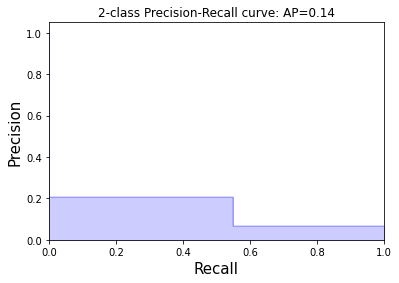

In [98]:
prc = average_precision_score(y_test, y_pred1)
#print("Precision Recall Score: {0:0.2f}" .format(prc),"%")
precision, recall, _ = precision_recall_curve(y_test, y_pred1)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

#plt.title('Precision Recall Curve for Xg Boost', fontsize = 25)
plt.xlabel('Recall', fontsize = 15)
plt.ylabel('Precision', fontsize =15)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(prc))

**KN NEIGHBOURS CLASSIFIER**

In [101]:
classifiers = [
               ['KNeighbours :', KNeighborsClassifier()],
               ]

for name,classifier in classifiers:
    clf=classifier.fit(x_train_oversample,y_train_oversample)
    y_pred2=classifier.predict(X_Filtered_test_2)
    print(f'\n {name} \n')
    print(f'Training Score for {name}  {clf.score(x_train_oversample,y_train_oversample) * 100:.2f}' )
    print(f'Testing Score for {name} {clf.score(X_Filtered_test_2,y_test) * 100:.2f}' )
    print(f'Classification report  \n {classification_report(y_test,y_pred2)}' )
    print(f'Confusion matrix  \n {confusion_matrix(y_test,y_pred2)}' )
    print(f'ROC AUC  : {roc_auc_score(y_test,y_pred2)}' )
    Specificity2 = np.float(13/31)
print("Specificity: ", Specificity2*100,"%")
px.imshow(confusion_matrix(y_test, y_pred2) , text_auto=True)
   # cm = confusion_matrix(y_test, y_pred)
    #print_confusion_matrix(cm,["Not Faulty","Faulty"])


 KNeighbours : 

Training Score for KNeighbours :  95.89
Testing Score for KNeighbours : 81.74
Classification report  
               precision    recall  f1-score   support

          -1       0.95      0.85      0.90       440
           1       0.16      0.42      0.23        31

    accuracy                           0.82       471
   macro avg       0.56      0.63      0.56       471
weighted avg       0.90      0.82      0.85       471

Confusion matrix  
 [[372  68]
 [ 18  13]]
ROC AUC  : 0.6324046920821114
Specificity:  41.935483870967744 %


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.11')

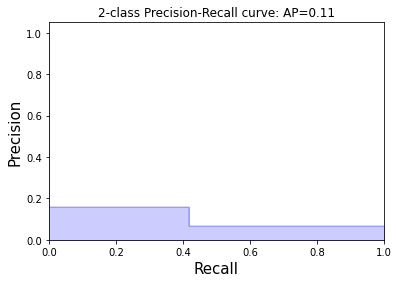

In [102]:
prc = average_precision_score(y_test, y_pred2)
#print("Precision Recall Score: {0:0.2f}" .format(prc),"%")
precision, recall, _ = precision_recall_curve(y_test, y_pred2)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

#plt.title('Precision Recall Curve for Xg Boost', fontsize = 25)
plt.xlabel('Recall', fontsize = 15)
plt.ylabel('Precision', fontsize =15)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(prc))

**SVM CLASSIFIER**


In [105]:
classifiers = [
               ['SVM :', SVC()]]

for name,classifier in classifiers:
    clf=classifier.fit(x_train_oversample,y_train_oversample)
    y_pred3=classifier.predict(X_Filtered_test_2)
    print(f'\n {name} \n')
    print(f'Training Score for {name}  {clf.score(x_train_oversample,y_train_oversample) * 100:.2f}' )
    print(f'Testing Score for {name} {clf.score(X_Filtered_test_2,y_test) * 100:.2f}' )
    print(f'Classification report  \n {classification_report(y_test,y_pred3)}' )
    print(f'Confusion matrix  \n {confusion_matrix(y_test,y_pred3)}' )
    print(f'ROC AUC  : {roc_auc_score(y_test,y_pred3)}' )
    Specificity3 = np.float(0/31)
print("Specificity: ", Specificity3*100,"%")
px.imshow(confusion_matrix(y_test, y_pred3) , text_auto=True)
   # cm = confusion_matrix(y_test, y_pred)
    #print_confusion_matrix(cm,["Not Faulty","Faulty"])


 SVM : 

Training Score for SVM :  89.87
Testing Score for SVM : 93.42
Classification report  
               precision    recall  f1-score   support

          -1       0.93      1.00      0.97       440
           1       0.00      0.00      0.00        31

    accuracy                           0.93       471
   macro avg       0.47      0.50      0.48       471
weighted avg       0.87      0.93      0.90       471

Confusion matrix  
 [[440   0]
 [ 31   0]]
ROC AUC  : 0.5
Specificity:  0.0 %


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.07')

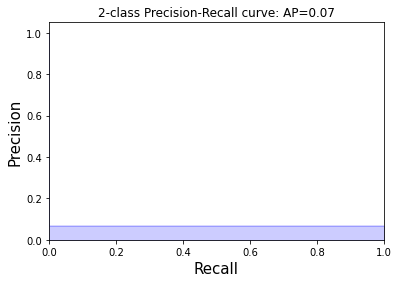

In [106]:
prc = average_precision_score(y_test, y_pred3)
#print("Precision Recall Score: {0:0.2f}" .format(prc),"%")
precision, recall, _ = precision_recall_curve(y_test, y_pred3)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

#plt.title('Precision Recall Curve for Xg Boost', fontsize = 25)
plt.xlabel('Recall', fontsize = 15)
plt.ylabel('Precision', fontsize =15)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(prc))

**LOGISTIC REGRESSION
 CLASSIFIER**

In [108]:
classifiers = [
               ['LogisticRegression :', LogisticRegression()],
              ]
for name,classifier in classifiers:
    clf=classifier.fit(x_train_oversample,y_train_oversample)
    y_pred4=classifier.predict(X_Filtered_test_2)
    print(f'\n {name} \n')
    print(f'Training Score for {name}  {clf.score(x_train_oversample,y_train_oversample) * 100:.2f}' )
    print(f'Testing Score for {name} {clf.score(X_Filtered_test_2,y_test) * 100:.2f}' )
    print(f'Classification report  \n {classification_report(y_test,y_pred4)}' )
    print(f'Confusion matrix  \n {confusion_matrix(y_test,y_pred4)}' )
    print(f'ROC AUC  : {roc_auc_score(y_test,y_pred4)}' )
    Specificity4 = np.float(12/31)
print("Specificity: ", Specificity4*100,"%")
px.imshow(confusion_matrix(y_test, y_pred4) , text_auto=True)
   # cm = confusion_matrix(y_test, y_pred)
    #print_confusion_matrix(cm,["Not Faulty","Faulty"])


 LogisticRegression : 

Training Score for LogisticRegression :  90.05
Testing Score for LogisticRegression : 90.66
Classification report  
               precision    recall  f1-score   support

          -1       0.96      0.94      0.95       440
           1       0.32      0.39      0.35        31

    accuracy                           0.91       471
   macro avg       0.64      0.67      0.65       471
weighted avg       0.91      0.91      0.91       471

Confusion matrix  
 [[415  25]
 [ 19  12]]
ROC AUC  : 0.6651392961876833
Specificity:  38.70967741935484 %


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.17')

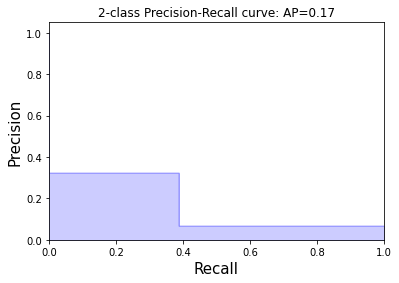

In [109]:
prc = average_precision_score(y_test, y_pred4)
#print("Precision Recall Score: {0:0.2f}" .format(prc),"%")
precision, recall, _ = precision_recall_curve(y_test, y_pred4)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

#plt.title('Precision Recall Curve for Xg Boost', fontsize = 25)
plt.xlabel('Recall', fontsize = 15)
plt.ylabel('Precision', fontsize =15)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(prc))

**DECISION TREE CLASSIFIER**

In [115]:
classifiers = [
               ['DecisionTree :',DecisionTreeClassifier()],
              ]

for name,classifier in classifiers:
    clf=classifier.fit(x_train_oversample,y_train_oversample)
    y_pred5=classifier.predict(X_Filtered_test_2)
    print(f'\n {name} \n')
    print(f'Training Score for {name}  {clf.score(x_train_oversample,y_train_oversample) * 100:.2f}' )
    print(f'Testing Score for {name} {clf.score(X_Filtered_test_2,y_test) * 100:.2f}' )
    print(f'Classification report  \n {classification_report(y_test,y_pred5)}' )
    print(f'Confusion matrix  \n {confusion_matrix(y_test,y_pred5)}' )
    print(f'ROC AUC  : {roc_auc_score(y_test,y_pred5)}' )
    Specificity5 = np.float(26/31)
print("Specificity: ", Specificity5*100,"%")
px.imshow(confusion_matrix(y_test, y_pred5) , text_auto=True)
   # cm = confusion_matrix(y_test, y_pred)
    #print_confusion_matrix(cm,["Not Faulty","Faulty"])



 DecisionTree : 

Training Score for DecisionTree :  100.00
Testing Score for DecisionTree : 56.90
Classification report  
               precision    recall  f1-score   support

          -1       0.98      0.55      0.70       440
           1       0.12      0.87      0.21        31

    accuracy                           0.57       471
   macro avg       0.55      0.71      0.46       471
weighted avg       0.93      0.57      0.67       471

Confusion matrix  
 [[241 199]
 [  4  27]]
ROC AUC  : 0.7093475073313784
Specificity:  83.87096774193549 %


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.11')

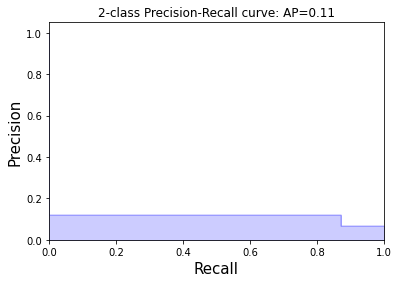

In [116]:
prc = average_precision_score(y_test, y_pred5)
#print("Precision Recall Score: {0:0.2f}" .format(prc),"%")
precision, recall, _ = precision_recall_curve(y_test, y_pred5)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

#plt.title('Precision Recall Curve for Xg Boost', fontsize = 25)
plt.xlabel('Recall', fontsize = 15)
plt.ylabel('Precision', fontsize =15)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(prc))

**RANDOMFOREST CLASSIFIER**

In [117]:
classifiers = [
               ['RandomForest :',RandomForestClassifier()]]

for name,classifier in classifiers:
    clf=classifier.fit(x_train_oversample,y_train_oversample)
    y_pred6=classifier.predict(X_Filtered_test_2)
    print(f'\n {name} \n')
    print(f'Training Score for {name}  {clf.score(x_train_oversample,y_train_oversample) * 100:.2f}' )
    print(f'Testing Score for {name} {clf.score(X_Filtered_test_2,y_test) * 100:.2f}' )
    print(f'Classification report  \n {classification_report(y_test,y_pred6)}' )
    print(f'Confusion matrix  \n {confusion_matrix(y_test,y_pred6)}' )
    print(f'ROC AUC  : {roc_auc_score(y_test,y_pred6)}' )
    Specificity6 = np.float(20/31)
print("Specificity: ", Specificity6*100,"%")
px.imshow(confusion_matrix(y_test, y_pred6) , text_auto=True)
   # cm = confusion_matrix(y_test, y_pred)
    #print_confusion_matrix(cm,["Not Faulty","Faulty"])


 RandomForest : 

Training Score for RandomForest :  100.00
Testing Score for RandomForest : 73.46
Classification report  
               precision    recall  f1-score   support

          -1       0.97      0.74      0.84       440
           1       0.15      0.65      0.24        31

    accuracy                           0.73       471
   macro avg       0.56      0.69      0.54       471
weighted avg       0.91      0.73      0.80       471

Confusion matrix  
 [[326 114]
 [ 11  20]]
ROC AUC  : 0.6930351906158358
Specificity:  64.51612903225806 %


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.12')

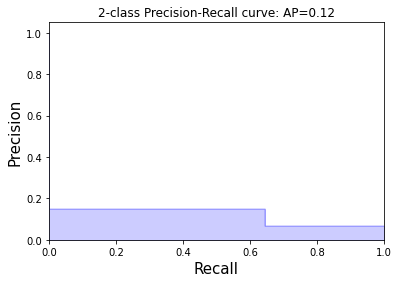

In [118]:
prc1 = average_precision_score(y_test, y_pred6)
#print("Precision Recall Score: {0:0.2f}" .format(prc),"%")
precision, recall, _ = precision_recall_curve(y_test, y_pred6)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

#plt.title('Precision Recall Curve for Xg Boost', fontsize = 25)
plt.xlabel('Recall', fontsize = 15)
plt.ylabel('Precision', fontsize =15)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(prc1))

ACURRACY BAR CHART

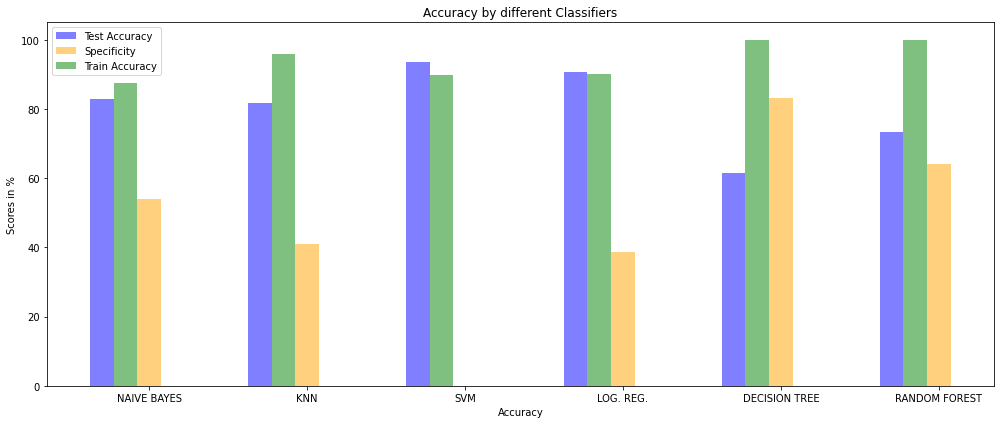

In [123]:
import matplotlib.pyplot as plt

# data to plot
n_groups = 6
Train_Accuracy = (87.50, 95.89, 89.87, 90.05, 100, 100)
Test_Accuracy = (83.01, 81.74, 93.42, 90.66, 61.36, 73.46 )
Specificity = (54, 41, 0, 38.70, 83.09, 64)
#Precision_Recall_Accuracy = (14, 11, 7, 17, 11, 12)

 
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.15
 
rects1 = plt.bar(index, Test_Accuracy, bar_width, alpha = 0.5, color = 'blue', label = 'Test Accuracy')
rects2 = plt.bar(index + 2*bar_width, Specificity, bar_width, alpha = 0.5, color = 'orange', label = 'Specificity')
#rects3 = plt.bar(index + 3*bar_width, Precision_Recall_Accuracy, bar_width, alpha = 0.5 , color = 'red', label = 'Precision Recall Accuracy' )
rects4 = plt.bar(index + bar_width, Train_Accuracy, bar_width, alpha = 0.5 , color = 'green', label = 'Train Accuracy' )

plt.rcParams['figure.figsize'] = (14, 6)
plt.xlabel('Accuracy')
plt.ylabel('Scores in %')
plt.title('Accuracy by different Classifiers')
plt.xticks(index + 2*bar_width, ('NAIVE BAYES', 'KNN', 'SVM','LOG. REG.', 'DECISION TREE', 'RANDOM FOREST'))
plt.legend()
plt.tight_layout()
plt.show()

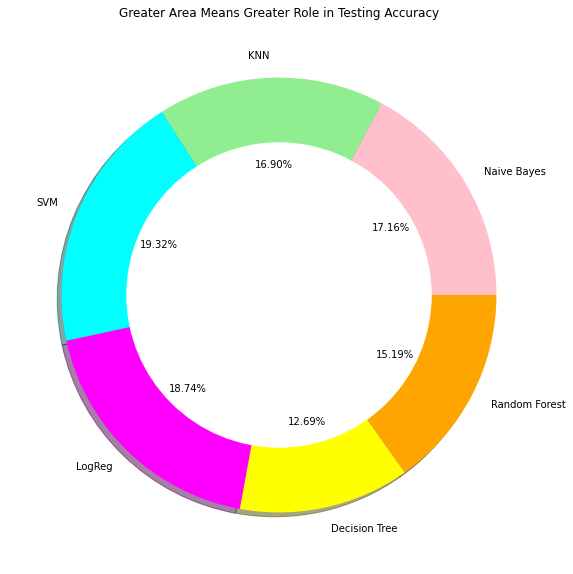

In [121]:
# defining the parameters for a pie chart

labels = "Naive Bayes", "KNN", "SVM", "LogReg", "Decision Tree", "Random Forest"
size = [83.01, 81.74, 93.42, 90.66, 61.36, 73.46]
colors = ['pink', 'lightgreen', 'cyan', 'magenta', 'yellow', 'orange', 'lightblue', 'crimson']

# Create a circle for the center of the plot
my_circle = plt.Circle( (0,0), 0.7, color = 'white')

plt.rcParams['figure.figsize'] = (10, 10)
plt.pie(size, colors = colors, labels = labels, shadow = True, autopct = '%.2f%%')
plt.title('Greater Area Means Greater Role in Testing Accuracy')
p = plt.gcf()
p.gca().add_artist(my_circle)
#plt.legend()
plt.show()